# Demonstration of Elliptical Iso-contour Fitting Using Photutils

Author: Himansh Rathore <br>
Teaching Assistant, <br>
ASTR400B: Galaxies & Cosmology, Spring-2025, University of Arizona <br>

References: <br>
1. https://photutils.readthedocs.io/en/stable/api/photutils.isophote.Ellipse.html <br>
2. https://photutils.readthedocs.io/en/stable/api/photutils.isophote.EllipseGeometry.html#photutils.isophote.EllipseGeometry <br>
3. https://photutils.readthedocs.io/en/latest/user_guide/isophote.html
4. https://photutils.readthedocs.io/en/latest/api/photutils.isophote.IsophoteList.html#photutils.isophote.IsophoteList

We will utlize the MW-M31-M33 simulation of van der Marel and Besla et al. 2012, ApJ 753 9. <br> 
We will try to fit elliptical iso-density contours to the dark matter halo of the Milky Way at t = 0, and derive the properties of these contours.

In [4]:
#necessary imports
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from ReadFile import Read
from CenterOfMass import CenterOfMass as COM
#you would need to install the packages below, uncomment the line below
#!pip install photutils
from photutils.isophote import EllipseGeometry
from photutils.aperture import EllipticalAperture
from photutils.isophote import Ellipse

## Loading snapshot

In [2]:
file = './MW_000.txt' #t = 0 particle data for the MW
_, _, data = Read(file) #reading particle data

## Extract the dark matter halo particles

In [3]:
dm_idxs = np.where(data['type'] == 1) #extracting the indices corresponding to the DM particles
#extracting positions of the dark matter particles
x = data['x'][dm_idxs]
y = data['y'][dm_idxs]
z = data['z'][dm_idxs]

## Centering the dark matter halo

In [11]:
myMWHalo = COM(file, 1) #creating the center of mass object
MW_COM = myMWHalo.COM_P(0.1) #center of mass of the dark matter halo using the shrinking sphere
x_COM, y_COM, z_COM = MW_COM[0], MW_COM[1], MW_COM[2] #note: these are astropy quantities

In [12]:
#centering
x1 = x - x_COM.value
y1 = y - y_COM.value
z1 = z - z_COM.value

## Lets plot the X-Y projection of the dark matter halo

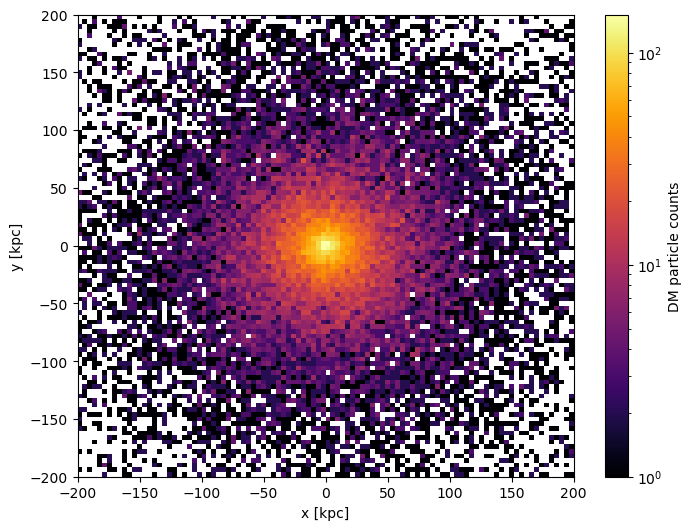

In [21]:
fig = plt.figure(figsize = (8, 6))
ax0 = fig.add_subplot(1, 1, 1)
_, _, _, plot = plt.hist2d(x1, y1, range = ((-200, 200), (-200, 200)), bins = 100, norm = LogNorm(), cmap = plt.cm.inferno)
fig.colorbar(plot, ax = ax0, label = 'DM particle counts')
ax0.set_xlabel('x [kpc]')
ax0.set_ylabel('y [kpc]')
plt.show()

## Ellipse Fitting

Lets try to fit Elliptical contours to the above dark matter distribution. First, we will have to construct a 2-D histogram of the dark matter particles distribution.

In [23]:
counts, xedges, yedges = np.histogram2d(x1, y1, bins = 100, range = ((-200, 200), (-200, 200)))
#our bin size is:
x_binsize = xedges[1] - xedges[0]
y_binsize = yedges[1] - yedges[0]

Photutils works in pixel coordinates - meaning it fits ellipses to an image. We need to convert kpc units into pixel units. <br>
For photutils images, the (0, 0) pixel corresponds to the bottom left corner of the image. This will be (-200, -200) kpc. <br>
We can relate the kpc units to pixel units using the binsize.

In [24]:
#converting the center into pixel units
x_cen_pixel = -xedges[0]/x_binsize
y_cen_pixel = -yedges[0]/y_binsize

### Initializing the Ellipse

We need to initialize photutils with a guess ellipse fit. This does not have to be accurate. We will choose the center of this ellipse to be the center of the image. i.e. (x_cen_pixel, y_cen_pixel) and the semi-major axis of the ellipse to be 50 kpc (converted to pixel units). We will choose the ellipticitly of this guess ellipse to be 0 and the position angle also to be 0. <br>
Note: ellipticity is defined as:
\begin{equation}
eps = 1 - \frac{b}{a}
\end{equation}
where, $b$ is the semi-minor axis and $a$ is the semi-major axis of the ellipse. <br>
Position angle is measured in radians, from x-axis in a counter-clockwise sense. <br>
See Refernce [3] for details.

In [26]:
#defining the ellipse geometry
geometry = EllipseGeometry(x0 = x_cen_pixel, y0 = y_cen_pixel, sma = 50/x_binsize, eps = 0, pa = 0)
#sma is the semi-major axis, eps is the ellipticity and pa is the position angle
#constructing the ellipse
aper = EllipticalAperture((geometry.x0, geometry.y0), geometry.sma, geometry.sma * (1 - geometry.eps), 
                           geometry.pa) 

Lets plot the guess ellipse. We will use imshow to plot the distribution of dark matter in pixel coordinates.

/tmp/ipykernel_11005/981562393.py:4: RuntimeWarning: divide by zero encountered in log10
  im = plt.imshow(np.log10(counts).T, cmap = cm, origin = "lower") #imshow transposes the matrix, so transposing again to reverse


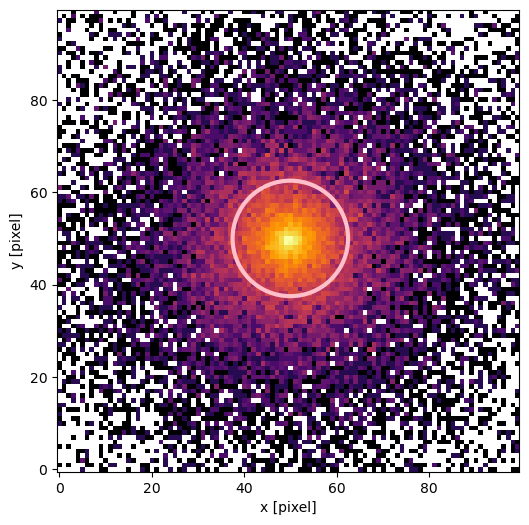

In [32]:
fig = plt.figure(figsize = (6, 6))
ax0 = fig.add_subplot(1, 1, 1)
cm = plt.cm.inferno
im = plt.imshow(np.log10(counts).T, cmap = cm, origin = "lower") #imshow transposes the matrix, so transposing again to reverse
ax0.set_xlabel('x [pixel]')
ax0.set_ylabel('y [pixel]')
aper.plot(color = 'pink', linewidth = 3)
plt.show()

### Performing the Fit

Note: this can take a minute or two depending on your binsize.

In [33]:
ellipse = Ellipse(counts.T, geometry) #initializing the ellipse object
#you need to transpose the counts matrix to reverse the effect of transposition that Ellipse does internally
isolist = ellipse.fit_image() 

isolist stores a list of objects - each object corresponds to an elliptical iso-contour that is fitted to the image.

### Plotting the Fitted Ellipses

We will plot the fitted elliptical contours for a range of semi-major axis, from 10 kpc to 150 kpc. We choose the contours to be separated by 20 kpc in semi-major axis.

/tmp/ipykernel_11005/812608268.py:4: RuntimeWarning: divide by zero encountered in log10
  im = plt.imshow(np.log10(counts).T, cmap = cm, origin = "lower")


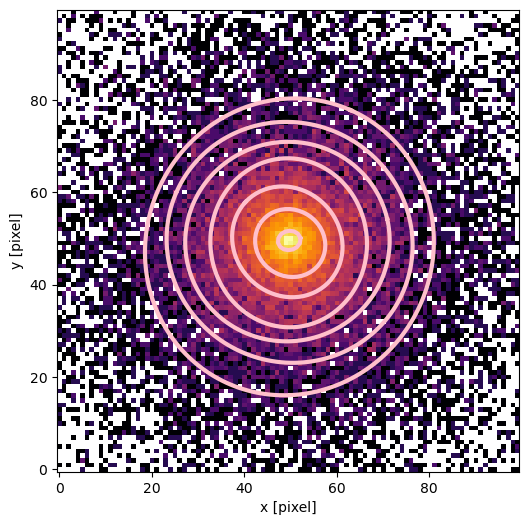

In [38]:
fig = plt.figure(figsize = (8, 6))
ax0 = fig.add_subplot(1, 1, 1)
cm = plt.cm.inferno
im = plt.imshow(np.log10(counts).T, cmap = cm, origin = "lower")
ax0.set_xlabel('x [pixel]')
ax0.set_ylabel('y [pixel]')

#defining the semi-major axes in pixel coordinates
sma_min = 10/x_binsize
sma_max = 150/x_binsize
separation = 20/x_binsize
sma_array = np.arange(sma_min, sma_max, separation) #each contour will be separated by 20 kpc

for my_sma in sma_array:
    iso = isolist.get_closest(my_sma)
    #the get_closest method obtains the elliptical contour whose semi-major axis is closest to what you want
    x, y = iso.sampled_coordinates()
    ax0.plot(x, y, color = 'pink', linewidth = 3)

plt.show()

## Extracting the Properties of the Fitted Ellipses

Lets extract the ellipse with a semi-major axis of 100 kpc.

In [39]:
sma_kpc = 100 #required semi-major axis in kpc
sma_pixel = 100/x_binsize #required semi-major axis in pixel units

#obtain the elliptical contour whose semi-major axis is closest to 100 kpc
iso_100 = isolist.get_closest(sma_pixel)

iso_100 is itself an object, and it has various methods which correspond to various properties of this ellipse - like ellipticity, position angle etc. Examples:

In [46]:
eps_100 = iso_100.eps
print("Ellipticity of 100 kpc elliptical contour: ", np.round(eps_100, 2))
pa_100 = (iso_100.pa)*180/np.pi #converting to degrees
print("Position angle of 100 kpc elliptical contour in degrees: ", np.round(pa_100, 2))

Ellipticity of 100 kpc elliptical contour:  0.03
Position angle of 100 kpc elliptical contour in degrees:  31.48


If you are extracting any property of the ellipse that has units (like semi-minor axis), make sure that you convert back to physical units from pixel units using the binsize. See reference [4] for a description of all the properties you can extract from these ellipses.